In [1]:
# general tools
import os
import sys
from glob import glob

# data tools
import re
import time
import h5py
import random
import numpy as np
from random import shuffle
from datetime import datetime, timedelta

In [2]:
from tensorflow import keras

2023-04-17 12:22:29.977300: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import importlib

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#tf.config.run_functions_eagerly(True)

sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import model_utils as mu


In [6]:
importlib.reload(mu)

<module 'model_utils' from '/glade/u/home/ksha/NCAR/libs/model_utils.py'>

In [7]:
# ==================== #
weights_round = 1
save_round = 2
seeds = 777
model_prefix_load = 'RE2_smooth_v4x_{}'.format(weights_round) #False
model_prefix_save = 'RE2_smooth_v4x_{}'.format(save_round)
N_vars = L_vars = 15
# ==================== #

In [8]:
# ----------------------------------------------------- #
# Collect pos and neg batch filenames

vers = ['v4x', 'v4'] # HRRR v4, v4x, v4
leads = [2, 3, 4, 5, 6, 20, 21, 22, 23]

filenames_pos = {}
filenames_neg = {}

# Identify and separate pos / neg batch files
for ver in vers:
    for lead in leads:
        if ver == 'v3':
            path_ = path_batch_v3
        elif ver == 'v4':
            path_ = path_batch_v4
        else:
            path_ = path_batch_v4x
            
        filenames_pos['{}_lead{}'.format(ver, lead)] = sorted(glob("{}*pos*lead{}.npy".format(path_, lead)))
        filenames_neg['{}_lead{}'.format(ver, lead)] = sorted(glob("{}*neg_neg_neg*lead{}.npy".format(path_, lead)))
        
        print('{}, lead{}, pos: {}, neg: {}'.format(ver, lead, len(filenames_pos['{}_lead{}'.format(ver, lead)]), 
                                             len(filenames_neg['{}_lead{}'.format(ver, lead)])))

v4x, lead2, pos: 1995, neg: 348553
v4x, lead3, pos: 1618, neg: 349958
v4x, lead4, pos: 1218, neg: 350358
v4x, lead5, pos: 962, neg: 350614
v4x, lead6, pos: 817, neg: 349731
v4x, lead20, pos: 1777, neg: 344659
v4x, lead21, pos: 2209, neg: 344227
v4x, lead22, pos: 2511, neg: 343925
v4x, lead23, pos: 2690, neg: 343746
v4, lead2, pos: 2174, neg: 402858
v4, lead3, pos: 1724, neg: 403308
v4, lead4, pos: 1349, neg: 403683
v4, lead5, pos: 1034, neg: 403998
v4, lead6, pos: 795, neg: 403209
v4, lead20, pos: 1941, neg: 403091
v4, lead21, pos: 2446, neg: 402586
v4, lead22, pos: 2791, neg: 402241
v4, lead23, pos: 2903, neg: 402129


In [9]:
# ----------------------------------------------------- #
# Separate train and valid from pos / neg batches
filenames_pos_train = {}
filenames_neg_train = {}

filenames_pos_valid = {}
filenames_neg_valid = {}

for ver in vers:
    for lead in leads:
        temp_namelist_pos = filenames_pos['{}_lead{}'.format(ver, lead)]
        temp_namelist_neg = filenames_neg['{}_lead{}'.format(ver, lead)]
        
        pos_train, pos_valid = mu.name_extract(temp_namelist_pos)
        neg_train, neg_valid = mu.name_extract(temp_namelist_neg)
        
        print('pos train: {} pos valid: {} neg train: {} neg valid {}'.format(len(pos_train), len(pos_valid), len(neg_train),len(neg_valid)))
        
        filenames_pos_train['{}_lead{}'.format(ver, lead)] = pos_train
        filenames_neg_train['{}_lead{}'.format(ver, lead)] = neg_train
        
        filenames_pos_valid['{}_lead{}'.format(ver, lead)] = pos_valid
        filenames_neg_valid['{}_lead{}'.format(ver, lead)] = neg_valid

pos train: 1452 pos valid: 543 neg train: 225736 neg valid 122817
pos train: 1187 pos valid: 431 neg train: 226001 neg valid 123957
pos train: 898 pos valid: 320 neg train: 226290 neg valid 124068
pos train: 721 pos valid: 241 neg train: 226467 neg valid 124147
pos train: 598 pos valid: 219 neg train: 225562 neg valid 124169
pos train: 1136 pos valid: 641 neg train: 220912 neg valid 123747
pos train: 1426 pos valid: 783 neg train: 220622 neg valid 123605
pos train: 1656 pos valid: 855 neg train: 220392 neg valid 123533
pos train: 1800 pos valid: 890 neg train: 220248 neg valid 123498
pos train: 0 pos valid: 13 neg train: 0 neg valid 29799
pos train: 0 pos valid: 10 neg train: 0 neg valid 29802
pos train: 0 pos valid: 8 neg train: 0 neg valid 29804
pos train: 0 pos valid: 8 neg train: 0 neg valid 29804
pos train: 0 pos valid: 8 neg train: 0 neg valid 29804
pos train: 0 pos valid: 7 neg train: 0 neg valid 29805
pos train: 0 pos valid: 7 neg train: 0 neg valid 29805
pos train: 0 pos valid

In [10]:
# ------------------------------------------------------------------ #
# Merge train/valid and pos/neg batch files from multiple lead times
pos_train_all = []
neg_train_all = []
pos_valid_all = []
neg_valid_all = []

for ver in vers:
    for lead in leads:
        pos_train_all += filenames_pos_train['{}_lead{}'.format(ver, lead)]
        neg_train_all += filenames_neg_train['{}_lead{}'.format(ver, lead)]
        pos_valid_all += filenames_pos_valid['{}_lead{}'.format(ver, lead)]
        neg_valid_all += filenames_neg_valid['{}_lead{}'.format(ver, lead)]

In [11]:
pos_train_v4x = []
neg_train_v4x = []

pos_train_v4 = []
neg_train_v4 = []

for lead in leads:
    pos_train_v4x += filenames_pos_train['{}_lead{}'.format('v4x', lead)]
    neg_train_v4x += filenames_neg_train['{}_lead{}'.format('v4x', lead)]
    
    pos_train_v4 += filenames_pos_train['{}_lead{}'.format('v4', lead)]
    neg_train_v4 += filenames_neg_train['{}_lead{}'.format('v4', lead)]

In [12]:
def neighbour_leads(lead):
    out = [lead-2, lead-1, lead, lead+1]
    flag_shift = [0, 0, 0, 0]
    
    for i in range(4):
        if out[i] < 0:
            out[i] = 24+out[i]
            flag_shift[i] = -1
        if out[i] > 23:
            out[i] = out[i]-24
            flag_shift[i] = +1
            
    return out, flag_shift

In [13]:
#label_smooth_v3 = ()
label_smooth_v4x = ()
label_smooth_v4 = ()

for lead in leads:

    lead_window, flag_shift = neighbour_leads(lead)
    
    print('Collect HRRR v4x labels ...')
    
    record_all = ()

    for i, lead_temp in enumerate(lead_window):

        flag_ = flag_shift[i]

        with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_v4x.hdf'.format(lead_temp), 'r') as h5io:
            record_temp = h5io['record_v4x'][...]

        if flag_shift[i] == 0:
            record_all = record_all + (record_temp,)

        if flag_shift[i] == -1:
            record_temp[1:, ...] = record_temp[:-1, ...]
            record_temp[0, ...] = np.nan
            record_all = record_all + (record_temp,)

        if flag_shift[i] == +1:
            record_temp[:-1, ...] = record_temp[1:, ...]
            record_temp[-1, ...] = np.nan
            record_all = record_all + (record_temp,)


    shape_record = record_temp.shape      
    record_v4x = np.empty(shape_record)
    record_v4x[...] = np.nan

    for i in range(4):
        record_temp = record_all[i]
        for day in range(shape_record[0]):
            for ix in range(shape_record[1]):
                for iy in range(shape_record[2]):
                    for event in range(shape_record[3]):
                        if record_temp[day, ix, iy, event] > 0:
                            record_v4x[day, ix, iy, event] = 1.0
                        elif record_v4x[day, ix, iy, event] == 1.0:
                            record_v4x[day, ix, iy, event] = 1.0
                        else:
                            record_v4x[day, ix, iy, event] = 0.0
    
    label_smooth_v4x += (record_v4x[None, ...],)
    
    print('... Done. Collect HRRR v4 labels ...')
    
    record_all = ()
    
    for i, lead_temp in enumerate(lead_window):

        flag_ = flag_shift[i]

        with h5py.File(save_dir_scratch+'SPC_to_lead{}_72km_all.hdf'.format(lead_temp), 'r') as h5io:
            record_temp = h5io['record_v4'][...]

        if flag_shift[i] == 0:
            record_all = record_all + (record_temp,)

        if flag_shift[i] == -1:
            record_temp[1:, ...] = record_temp[:-1, ...]
            record_temp[0, ...] = np.nan
            record_all = record_all + (record_temp,)

        if flag_shift[i] == +1:
            record_temp[:-1, ...] = record_temp[1:, ...]
            record_temp[-1, ...] = np.nan
            record_all = record_all + (record_temp,)
            
            
    shape_record = record_temp.shape      
    record_v4 = np.empty(shape_record)
    record_v4[...] = 0.0 #np.nan

    for i in range(4):
        record_temp = record_all[i]
        for day in range(shape_record[0]):
            for ix in range(shape_record[1]):
                for iy in range(shape_record[2]):
                    for event in range(shape_record[3]):
                        if record_temp[day, ix, iy, event] > 0:
                            record_v4[day, ix, iy, event] = 1.0
                        elif record_v4[day, ix, iy, event] == 1.0:
                            record_v4[day, ix, iy, event] = 1.0
                        else:
                            record_v4[day, ix, iy, event] = 0.0
                            
    label_smooth_v4 += (record_v4[None, ...],)
    
    print('... Done')

Collect HRRR v4x labels ...
... Done. Collect HRRR v4 labels ...
... Done
Collect HRRR v4x labels ...
... Done. Collect HRRR v4 labels ...
... Done
Collect HRRR v4x labels ...
... Done. Collect HRRR v4 labels ...
... Done
Collect HRRR v4x labels ...
... Done. Collect HRRR v4 labels ...
... Done
Collect HRRR v4x labels ...
... Done. Collect HRRR v4 labels ...
... Done
Collect HRRR v4x labels ...
... Done. Collect HRRR v4 labels ...
... Done
Collect HRRR v4x labels ...
... Done. Collect HRRR v4 labels ...
... Done
Collect HRRR v4x labels ...
... Done. Collect HRRR v4 labels ...
... Done
Collect HRRR v4x labels ...
... Done. Collect HRRR v4 labels ...
... Done


In [14]:
# label smoothing operations
# plt.pcolormesh(np.sum(label_smooth_v3[0], axis=-1)[0, 1, ...])
# No v4 data were applied for training

In [15]:
label_concat_v4x = np.concatenate(label_smooth_v4x, axis=0)
label_concat_v4 = np.concatenate(label_smooth_v4, axis=0)

In [16]:
label_concat_v4 = np.sum(label_concat_v4, axis=-1)
label_concat_v4[label_concat_v4>1] = 1

label_concat_v4x = np.sum(label_concat_v4x, axis=-1)
label_concat_v4x[label_concat_v4x>1] = 1

In [17]:
import scipy.ndimage

In [18]:
shape_label_v4 = label_concat_v4.shape
shape_label_v4x = label_concat_v4x.shape

In [19]:
label_final_v4 = np.empty(shape_label_v4)
label_final_v4x = np.empty(shape_label_v4x)

In [20]:
for i in range(shape_label_v4[0]):
    for j in range(shape_label_v4[1]):
        label_final_v4[i, j, ...] = scipy.ndimage.gaussian_filter(label_concat_v4[i, j], sigma=2.0)

In [21]:
for i in range(shape_label_v4x[0]):
    for j in range(shape_label_v4x[1]):
        label_final_v4x[i, j, ...] = scipy.ndimage.gaussian_filter(label_concat_v4x[i, j], sigma=2.0)

In [22]:
# f_v4 = np.max(label_final_v4)
# f_v4x = np.max(label_final_v4x)

In [23]:
def filename_to_loc(filenames):
    lead_out = []
    indx_out = []
    indy_out = []
    day_out = []
    
    for i, name in enumerate(filenames):
        
        nums = re.findall(r'\d+', name)
        
        lead = int(nums[-1])
        indy = int(nums[-2])
        indx = int(nums[-3])
        day = int(nums[-4])
      
        indx_out.append(indx)
        indy_out.append(indy)
        day_out.append(day)
        lead_out.append(lead)
        
    return np.array(indx_out), np.array(indy_out), np.array(day_out), np.array(lead_out)

In [24]:
indx_pos_train_v4x, indy_pos_train_v4x, day_pos_train_v4x, lead_pos_train_v4x = filename_to_loc(pos_train_v4x)
indx_neg_train_v4x, indy_neg_train_v4x, day_neg_train_v4x, lead_neg_train_v4x = filename_to_loc(neg_train_v4x)

# leads = [2, 3, 4, 5, 6, 20, 21, 22, 23]

lead_pos_train_v4x = lead_pos_train_v4x - 2
lead_pos_train_v4x[lead_pos_train_v4x==18] = 5
lead_pos_train_v4x[lead_pos_train_v4x==19] = 6
lead_pos_train_v4x[lead_pos_train_v4x==20] = 7
lead_pos_train_v4x[lead_pos_train_v4x==21] = 8

lead_neg_train_v4x = lead_neg_train_v4x - 2
lead_neg_train_v4x[lead_neg_train_v4x==18] = 5
lead_neg_train_v4x[lead_neg_train_v4x==19] = 6
lead_neg_train_v4x[lead_neg_train_v4x==20] = 7
lead_neg_train_v4x[lead_neg_train_v4x==21] = 8

In [25]:
y_pos_train_v4x = label_final_v4x[lead_pos_train_v4x, day_pos_train_v4x, indx_pos_train_v4x, indy_pos_train_v4x]
y_neg_train_v4x = label_final_v4x[lead_neg_train_v4x, day_neg_train_v4x, indx_neg_train_v4x, indy_neg_train_v4x]

In [26]:
# plt.hist(y_pos_train_v4x, log=True, density=True);
# plt.hist(y_neg_train_v4x, log=True, density=True);

In [27]:
#vers = ['v3', 'v4x', 'v4']
y_pos_train_all = y_pos_train_v4x
y_neg_train_all = y_neg_train_v4x

In [28]:
y_pos_train_all_adjust = np.copy(y_pos_train_all) + 0.75
y_pos_train_all_adjust[y_pos_train_all_adjust>0.99] = 0.99

In [29]:
y_neg_train_all_adjust = np.copy(y_neg_train_all)
y_neg_train_all_adjust[y_neg_train_all_adjust>0.19] = 0.19

In [30]:
ind_pick_from_batch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [31]:
# ----------------------------------------------------------------- #
# Load valid files for model training

filename_valid = neg_valid_all[::220] + pos_valid_all[::13]
#filename_valid = filename_valid[::2]
L_valid = len(filename_valid)
print('number of validation batches: {}'.format(L_valid))

number of validation batches: 6666


In [32]:
VALID_input_64 = np.empty((L_valid, 64, 64, L_vars))
VALID_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        VALID_input_64[i, ..., k] = data[..., c]

        if 'pos' in name:
            VALID_target[i] = 1.0
        else:
            VALID_target[i] = 0.0

In [33]:
# ----------------------------------------------------------------- #
# model and weights
model_head = mu.create_model_head(input_shape=(128,), N_node=64)
model_base = mu.create_model_base(input_shape=(64, 64, 15), depths=[3, 3, 27, 3], projection_dims=[32, 64, 96, 128])

IN = keras.layers.Input(shape=(64, 64, 15))

VEC = model_base(IN)
OUT = model_head(VEC)

model_final = keras.models.Model(inputs=IN, outputs=OUT)

2023-04-17 12:40:18.331080: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-17 12:40:18.334346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-17 12:40:18.444990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-04-17 12:40:18.445118: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-17 12:40:18.674405: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-17 12:40:18.674494: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [34]:
# ============================================= #
# Weights

if weights_round > 0:
    if model_prefix_load:
        W_old = mu.dummy_loader('/glade/work/ksha/NCAR/Keras_models/{}/'.format(model_prefix_load))
        model_final.set_weights(W_old)
    
model_final.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(lr=1e-5))


In [35]:
# ----------------------------------------------------------------- #
# model training loop
Y_pred = model_final.predict([VALID_input_64])
record_temp = mu.verif_metric(VALID_target, Y_pred)

0.026994786611353586


In [36]:
# Change based on smoothed labels
print(record_temp)

0.03252324946707268


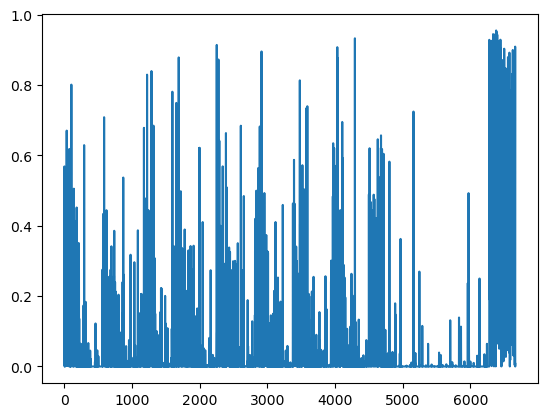

In [37]:
plt.plot(Y_pred)

In [38]:
# training parameters
epochs = 500
L_train = 64
min_del = 0.0
max_tol = 100 # early stopping with patience
batch_size = 200

# Allocate batch files
X_batch_64 = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch_64[...] = np.nan
Y_batch[...] = np.nan

# Model check-point info
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'
model_name = model_prefix_save
model_path = temp_dir + model_name

# ========== Training loop ========== #
tol = 0 # initial tol

filename_pos_train = pos_train_all
filename_neg_train = neg_train_all
L_pos = len(filename_pos_train)
L_neg = len(filename_neg_train)

record = record_temp
print("Initial record: {}".format(record))

mu.set_seeds(seeds)
    
for i in range(epochs):
    start_time = time.time()

    # loop of batch
    for j in range(L_train):
        N_pos = 20
        N_neg = batch_size - N_pos

        ind_neg = du.shuffle_ind(L_neg)
        ind_pos = du.shuffle_ind(L_pos)
        
        # neg batches from this training rotation 
        file_pick_neg = []
        file_label_neg = []
        for ind_temp in ind_neg[:N_neg]:
            file_pick_neg.append(filename_neg_train[ind_temp])
            file_label_neg.append(y_neg_train_all_adjust[ind_temp])
            
        # pos batches from this training rotation 
        file_pick_pos = []
        file_label_pos = []
        for ind_temp in ind_pos[:N_pos]:
            file_pick_pos.append(filename_pos_train[ind_temp])
            file_label_pos.append(y_pos_train_all_adjust[ind_temp])
            
        # get all the batch filenames for checking labels
        file_pick = file_pick_neg + file_pick_pos
        file_label = file_label_neg + file_label_pos
        Y_batch = np.array(file_label)[:, None]
        
#         if len(file_pick) != batch_size:
#             sregwet # number of available files = batch size

        # Assign labels based on batch filenames
        for k in range(batch_size):
            data = np.load(file_pick[k])
            for l, c in enumerate(ind_pick_from_batch):
                temp = data[..., c] 
                X_batch_64[k, ..., l] = temp

#             if 'pos' in file_pick[k]:
#                 Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
#             elif 'neg_neg_neg' in file_pick[k]:
#                 Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
#             else:
#                 werhgaer
        # ------------------------------------------------- #
        # batch input and label from this training rotation 
        ind_ = du.shuffle_ind(batch_size)
        X_batch_64 = X_batch_64[ind_, ...]
        Y_batch = Y_batch[ind_, :]

        # train on batch
        model_final.train_on_batch(X_batch_64, Y_batch);

    # epoch end operations
    Y_pred = model_final.predict([VALID_input_64])
    record_temp = mu.verif_metric(VALID_target, Y_pred)

    if (record - record_temp > min_del):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        print('save to: {}'.format(model_path))
        model_final.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        if record_temp >= 2.0:
            print('Early stopping')
            break;
        else:
            tol += 1
            if tol >= max_tol:
                print('Early stopping')
                break;
            else:
                continue;
    print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 0.03252324946707268
0.031898757946693654
Validation loss improved from 0.03252324946707268 to 0.031898757946693654
save to: /glade/work/ksha/NCAR/Keras_models/RE2_smooth_v4x_2


2023-04-17 12:47:00.373105: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE2_smooth_v4x_2/assets
--- 383.02738094329834 seconds ---
0.03195855049616534
Validation loss 0.03195855049616534 NOT improved
0.03193827331039154
Validation loss 0.03193827331039154 NOT improved
0.03204625027728145
Validation loss 0.03204625027728145 NOT improved
0.03317368876291731
Validation loss 0.03317368876291731 NOT improved
0.032331024322279876
Validation loss 0.032331024322279876 NOT improved
0.03274739966275104
Validation loss 0.03274739966275104 NOT improved
0.031945524712653696
Validation loss 0.031945524712653696 NOT improved
0.03156875023234683
Validation loss improved from 0.031898757946693654 to 0.03156875023234683
save to: /glade/work/ksha/NCAR/Keras_models/RE2_smooth_v4x_2
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE2_smooth_v4x_2/assets
--- 478.7881586551666 seconds ---
0.03178283036363374
Validation loss 0.03178283036363374 NOT improved
0.03210459273198945
Validation l


KeyboardInterrupt



In [ ]:
Y_batch.shape